C:\Users\h02317\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\h02317\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\h02317\AppData\Roaming\Python\Python310\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\h02317\AppData\Roaming\Python\Python31

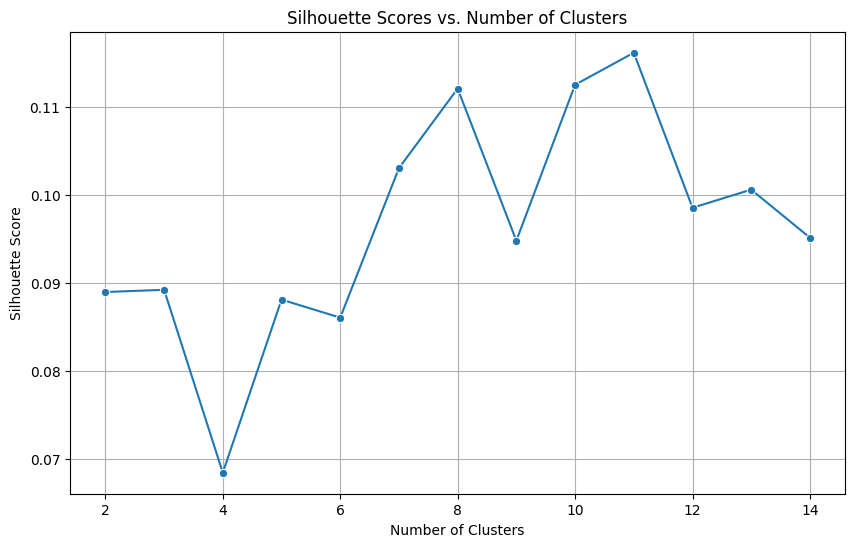

Optimal number of clusters based on silhouette score: 11


C:\Users\h02317\AppData\Roaming\Python\Python310\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\h02317\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0 Label: Biomedical Engineering and Robotics
 - Mobile microscopy for resource-poor settings
 - self-assembly
 - robotics


Cluster 1 Label: Computational Statistics and Optimization
 - Amortized inference
 - Bayesian optimization
 - Optimization
 - multiobjective optimization
 - evolutionary algorithms
 - Formal languages
 - Bayesian statistics
 - model selection
 - stochastic analysis
 - Numerical analysis
 - combinatorial optimization
 - optimization


Cluster 2 Label: Food Safety and Quality Chemistry
 - Mycotoxins and other contaminants in food and feed
 - Chemical safety and risk assessment of food and feed additives and contaminants
 - Residues of veterinary drugs and other contaminants in food and feed
 - Authentication of food origin using chemical and isotopic techniques
 - Chemical and sensory quality of food
 - Legislation and control of food and feed safety


Cluster 3 Label: Biochemistry and Molecular Biology
 - Protein-protein interactions
 - Protein structure an

In [1]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
import requests
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
from scipy.spatial import ConvexHull

TERM_EMBEDDINGS = 1
# Function to encode text to embeddings
def encode_texts(texts):
    with torch.no_grad():  # Do not compute gradients to save memory and computations
        encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
        model_output = model(**encoded_input)
        embeddings = model_output.last_hidden_state.mean(dim=1)
    return embeddings
    
# Load the dataset
file_path = 'researchers.xlsx'
df = pd.read_excel(file_path)

if not TERM_EMBEDDINGS:  ##we want to cluster by rows. That means all the research interests of a researcher will be considered as a single data point.
    # Extract unique research interests
    unique_interests = df['Research Interests'].unique()
else:
    # # Split research interests by comma and find unique interests. Research interests are split by comma. Each considered an individual data point.
    all_interests = df['Research Interests'].str.split(',').explode().str.strip()
    unique_interests = all_interests.unique()
    
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Encode unique research interests
embeddings = encode_texts(unique_interests.tolist())

# Find the optimal number of clusters based on silhouette scores
silhouette_scores = []
K_range = range(2, 15)  # Testing a reasonable range for the number of clusters

for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=42).fit(embeddings.numpy())
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(embeddings.numpy(), labels))

# Plot silhouette scores
plt.figure(figsize=(10, 6))
sns.lineplot(x=K_range, y=silhouette_scores, marker="o", dashes=False)
plt.title("Silhouette Scores vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

optimal_K = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_K}")

# Dimensionality reduction with UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(embeddings.numpy())

# Clustering with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_K, random_state=42).fit(umap_embeddings)
cluster_labels = kmeans_optimal.labels_

cluster_labels = kmeans_optimal.labels_  # Assuming this is the result of K-means with optimal_K

# Create a DataFrame to associate each research interest with its cluster
interests_df = pd.DataFrame({
    'Research Interest': unique_interests,
    'Cluster': cluster_labels
})

# Group the research interests by their cluster
grouped_interests = interests_df.groupby('Cluster')['Research Interest'].apply(list)

###the clusters are sent to GPT-4 for labelling. 
# Configuration
GPT4V_KEY = ""  ### Insert your OpenAI API key here.
headers = {
    "Content-Type": "application/json",
    "api-key": GPT4V_KEY,
}
GPT4V_ENDPOINT = "https://hhazure-openai-dev.openai.azure.com/openai/deployments/GPT4Vision/chat/completions?api-version=2023-07-01-preview"

# Assuming 'grouped_interests' is your variable that holds clusters and their respective interests
for cluster, interests in grouped_interests.items():
    # Prepare the input message with the list of research interests for the cluster
    input_message = "Based on the following research interests: " + ", ".join(interests) + ". \
    What is a high-level label or domain that represents these interests? The topic should be concise representing a whole domain or field." 

    # Define what you expect from GPT-4
    system_message = "Generate a high-level label representing the domain of the provided research interests."

    # Prepare the payload
    payload = {
        "messages": [
            {
                "role": "system",
                "content": system_message
            },
            {
                "role": "user",
                "content": input_message
            }
        ],
        "max_tokens": 2000
    }

    # Send request
    try:
        response = requests.post(GPT4V_ENDPOINT, headers=headers, json=payload)
        response.raise_for_status()  # Will raise an HTTPError if the HTTP request returned an unsuccessful status code.
        # Handle the response
        response_json = response.json()  # Assuming 'response' is your response object
        cluster_label = response_json['choices'][0]['message']['content'] if response_json.get('choices') else "No response content."
        print(f"Cluster {cluster} Label: {cluster_label}")
        for interest in interests:
            print(f" - {interest}")
        print("\n")  # Add a newline for better readability between clusters
    except requests.RequestException as e:
        print(f"Failed to make the request for Cluster {cluster}. Error: {e}")
    time.sleep(60)#for some reasons, I can't send quick reasons to GPT-4V. So I set a timer here.
print('Done finding clusters...')

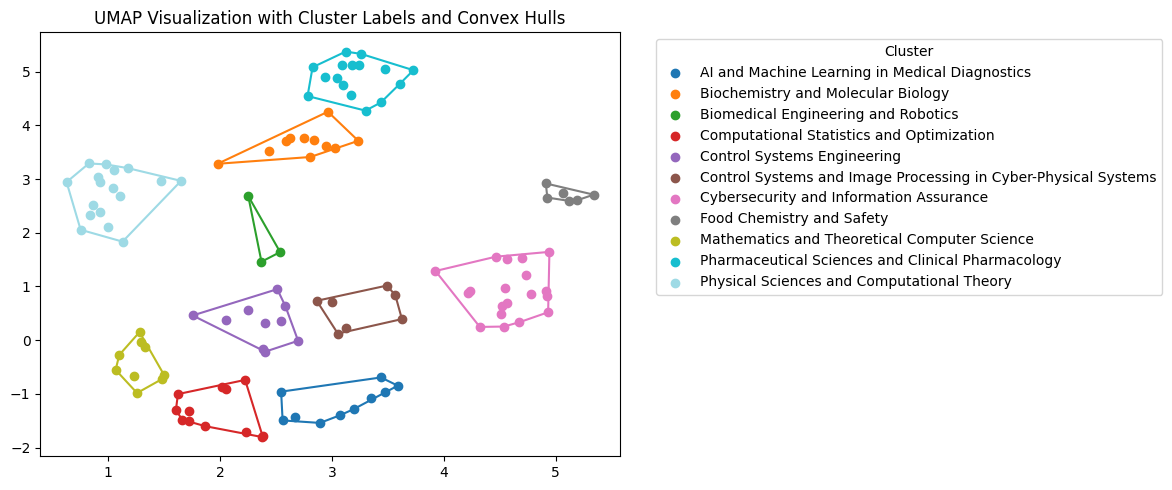

DataFrame updated with cluster information and saved.


In [34]:
cluster_labels_mapping = {
    0: "Biomedical Engineering and Robotics",
    1: "Computational Statistics and Optimization",
    2: "Food Chemistry and Safety",
    3: "Biochemistry and Molecular Biology",
    4: "Physical Sciences and Computational Theory",
    5: "Cybersecurity and Information Assurance",
    6: "Control Systems and Image Processing in Cyber-Physical Systems",
    7: "AI and Machine Learning in Medical Diagnostics",
    8: "Mathematics and Theoretical Computer Science",
    9: "Control Systems Engineering",
    10:"Pharmaceutical Sciences and Clinical Pharmacology"
}

# Convert cluster numbers to labels for plotting
cluster_labels = [cluster_labels_mapping[label] for label in kmeans_optimal.labels_]
data = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
data['cluster'] = cluster_labels  # Add cluster assignments

plt.figure(figsize=(12, 5))

# Define colors for each cluster for consistency with hulls
colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(data['cluster']))))

for i, cluster in enumerate(np.unique(data['cluster'])):
    # Select data for the current cluster
    points = data[data['cluster'] == cluster][['x', 'y']].values
    # Compute the convex hull
    hull = ConvexHull(points)
    # Plot the data points
    plt.scatter(points[:, 0], points[:, 1], color=colors[i], label=f'{cluster}')
    # Plot the convex hull
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], color=colors[i])

plt.title('UMAP Visualization with Cluster Labels and Convex Hulls')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'C:/Users/h02317/Downloads/clusters.png',dpi=600)
plt.show()


# Map each unique research interest back to its cluster label
interest_to_cluster_label = dict(zip(unique_interests, cluster_labels))

# Add a new 'Cluster' column to the original df, mapping each research interest to its cluster label
df['Cluster'] = df['Research Interests'].map(interest_to_cluster_label)

# Save the updated DataFrame with cluster information
df.to_excel('updated_researchers_with_clusters_term_based.xlsx', index=False)

print("DataFrame updated with cluster information and saved.")

In [44]:
import pandas as pd
import requests
import json
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import re
from IPython.display import display
from IPython.display import display, HTML

# Configuration
GPT4V_KEY = "e08d4bae1d104dfdb8ceb3e063b7ef7e"  # Insert your actual OpenAI API key
headers = {
    "Content-Type": "application/json",
    "api-key": GPT4V_KEY,
}
GPT4V_ENDPOINT = "https://hhazure-openai-dev.openai.azure.com/openai/deployments/GPT4Vision/chat/completions?api-version=2023-07-01-preview"

# Load the updated dataset with clusters
df = pd.read_excel('updated_researchers_with_clusters_term_based.xlsx')

# Step 1: Split the research interests by comma for each entry and flatten the list
all_interests = df['Research Interests'].str.split(',').explode().tolist()

# Step 2: Remove leading/trailing spaces and convert to lowercase (optional) for uniformity
all_interests = [interest.strip().lower() for interest in all_interests]

# Step 3: Use set to remove duplicates and then convert back to list to get unique interests
unique_interests = list(set(all_interests))


unique_clusters = list(cluster_labels_mapping.values())

# The abstract to be analyzed
abstract = "For many problems of interest in machine learning and control, we have access to rich information about underlying geometry and dynamics;\
we can leverage this information to build robust and performant solutions in new algorithms, optimizations, and designs. In this research proposal we\
study four problem settings to stress this central assumption. First, we study conformal generative modeling, using computational geometry techniques\
to simplify and register complex 2D surfaces and enabling the use of a variety of flow-based generative models as plug-and-play subroutines. Second,\
we study data-driven robust optimization problems in control, modeling the precise impact of dynamics uncertainty in several control frameworks using\
convex geometry. Third, we study compactly-restrictable policy optimization, constraining the available states and actions in reinforcement learning\
and optimal control problems to be consistent with the inherent dynamics of the systems to be controlled. Finally, we study nonlinear model \
predictive control on Lie groups as applied to a 3D hopping robot platform, developing a control methodology compatible with nontrivial state space\
geometry and hybrid system dynamics."

# Prepare the input and system messages for GPT-4V
input_message = f"Given the abstract: '{abstract}', extract maximum five key topics and one major field that the abstract falls in. \
The key topics should come from the list: {', '.join(unique_interests)} and the major field should come from the list:  \
{', '.join(unique_clusters)}. Do not make up any topics. Write only key topics and major filed, and no other text.\
The extracted topics should come from the given fields only. Use a strict approach for matching.\
If you cannot find any matching key topic or field, simply respond with 'No topic found'. Do not always try to extract all five topics. \
If you find less than five key topics, only extract those topics. Do not make up any topic. "
system_message = "Analyze the abstract to find maximum five key topics and one major field the abstract falls in. If there is no matching, do not \
make up topics, and answer with 'no matching topics found'."

# Prepare the payload
payload = {
    "messages": [
        {
            "role": "system",
            "content": system_message
        },
        {
            "role": "user",
            "content": input_message
        }
    ],
    "max_tokens": 2000
}


# Send request
try:
    response = requests.post(GPT4V_ENDPOINT, headers=headers, json=payload)
    response.raise_for_status()  # Checks for HTTP errors
    # Handle the response to extract the content
    response_json = response.json()  # Parse the JSON response
    topics_response = response_json['choices'][0]['message']['content']
    # Adjusted regular expression patterns to match the actual format
    key_topics_pattern = r"Key Topics:(.*?)\n\nMajor Field:"
    match = re.search(key_topics_pattern, topics_response, re.DOTALL)
    if match:
        key_topics_text = match.group(1)
        # Remove numbering and extra whitespace
        key_topics = [topic.strip() for topic in re.sub(r"\d+\.\s*", "", key_topics_text).split("\n") if topic.strip()]
    else:
        key_topics = []
    
    major_field_pattern = r"Major Field:\s*(.*)"
    match = re.search(major_field_pattern, topics_response, re.DOTALL)
    major_field = match.group(1).strip() if match else ""

    if key_topics:
        key_topics = [', '.join(key_topics)]
        # Initialize the tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
        model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
        
        def get_embedding(text):
            with torch.no_grad():
                encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
                output = model(**encoded_input)
                return output.last_hidden_state.mean(dim=1).numpy()
        
        # Load the DataFrame
        df = pd.read_excel('researchers.xlsx')
        
        # Compute embeddings for 'Research Interests' 
        df['Research Interest Embedding'] = df['Research Interests'].apply(lambda x: get_embedding(x))
        
        # Compute embeddings for key topics
        key_topic_embeddings = np.array([get_embedding(topic) for topic in key_topics])
       
        # Flatten the embeddings for comparison
        research_interest_embeddings = np.vstack(df['Research Interest Embedding'].values)
        
        # Compute similarities for key topics
        topic_similarities = np.array([cosine_similarity(research_interest_embeddings, topic_embedding.reshape(1, -1)).flatten() for topic_embedding in key_topic_embeddings])
        
        # Average topic similarities 
        total_similarity = np.mean(topic_similarities, axis=0)
        normalized_similarity = total_similarity
        
        # Find top three matches
        top_matches_indices = normalized_similarity.argsort()[-5:][::-1]
        
        # print(f"The extracted topics and fields from the abstract:\n {topics_response}")

        print(f"The given abstract falls in the major field of {major_field}. The key topics include:\n")
        for topic in key_topics:
            print(f"{topic}")
            
        # Display top matching experts
        print("\nTop Matching Experts:")
        # Initialize a list to store expert data
        experts_data = []
        
        # Loop through the top matching indices to gather data
        for i, index in enumerate(top_matches_indices, start=1):
            similarity_score = normalized_similarity[index]
            expert_info = {
                "Expert": f"Expert {i}",
                "Name": df.iloc[index]['Name'],
                "Affiliation": df.iloc[index]['Affiliation'],  # Assuming 'Affiliation' column exists
                "Email": df.iloc[index]['Email'],  # Assuming 'Email' column exists
                "Research Interests": df.iloc[index]['Research Interests'],
                #"Cluster": df.iloc[index]['Cluster'],
                "Matching Score": f"{similarity_score:.4f}"  # You might choose to include the similarity score as well
            }
            experts_data.append(expert_info)
        
        # Convert the list of dictionaries into a DataFrame
        experts_df = pd.DataFrame(experts_data)
        
        # Display the DataFrame
        display(HTML(experts_df.to_html(index=False)))
    else:
        print("No matching topic or field found for this abstract...")
except requests.RequestException as e:
    print(f"Request to GPT-4V failed: {e}")

The given abstract falls in the major field of Control Systems Engineering. The key topics include:

Machine learning, Optimization, Model predictive control, Control theory, Robust control

Top Matching Experts:


Expert,Name,Affiliation,Email,Research Interests,Matching Score
Expert 1,Antti-Pekka Pietila,University of Jyväskylä,antti-pekka.pietila@jyu.fi,"Control theory, optimization, machine learning",0.8601
Expert 2,Janne Lundell,Åbo Akademi University,janne.lundell@abo.fi,"Predictive control, optimization, process control",0.7180
Expert 3,Mikko Valkama,University of Oulu,mikko.valkama@oulu.fi,"Intelligent control, machine learning, robotics",0.6760
Expert 4,Petri Dankohn,Aalto University,petri.dankohn@aalto.fi,"System identification, robust control, nonlinear control",0.5700
Expert 5,Heikki Koivu,Tampere University,heikki.koivu@tuni.fi,"Control of hybrid systems, cyber-physical systems, model predictive control",0.5596
